In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
class Args:
    def __init__(self):
        self.peak_freq = 12        # not used
        self.seconds = 3000        # number of seconds of data to generate
        self.events = 4            # number of events
        self.sim_num_channels = 1  # number of channels
        self.sim_ar_order = 2      # order of AR model (2 is used for generating specific oscillations)
        self.gamma_shape = 10       # shape parameter for gamma distribution
        self.gamma_scale = 10       # scale parameter for gamma distribution
        self.noise_std = 2.5       # global noise variance to add on top of generated data
        self.lambda_exp = 0.005     # exponent parameter for damping AR
        self.ar_shrink = 1.0      # shrinking AR coefficients so the simulation doesn't explode
        self.freqs = [8, 17, 30, 45]     # frequencies of the different events
        self.ar_noise_std = np.random.rand(self.events) / 5 + 0.8   # noise variance of the AR model for each event
        self.max_len = 500        # maximum length of an event in timesteps
        self.load_data = ''        # not used
        self.sample_rate = 250     # sample rate of generated data

args = Args()

In [6]:
class EventSimulation:
    def __init__(self, args):
        self.args = args

        self.gamma = np.random.gamma(args.gamma_shape,
                                     args.gamma_scale,
                                     args.seconds)
        self.gamma = self.gamma.astype(int)
        self.gamma = np.array([g for g in self.gamma if g < args.max_len])

        data_length = np.sum(self.gamma) + args.sim_ar_order
        self.data = np.random.randn(args.sim_num_channels, data_length)
        self.noise = np.random.normal(
            0, args.noise_std, (args.sim_num_channels, data_length))
        self.ar_noise_std = np.random.randn(args.events)

        # define the parameters of the simulation then generate data
        self.fill(args)
        self.generate(args)

    def fill(self, args):
        # AR coefficients for specific frequencies.
        freqs = [2*np.cos(2*np.pi*f/args.sample_rate) for f in args.freqs]
        self.AR = np.array([[f, -1] for f in freqs])
        self.AR *= args.ar_shrink
        self.AR = self.AR.reshape(args.events, 1, 1, args.sim_ar_order)
        
        self.ar_noise_std = np.array(args.ar_noise_std)

        probs = []
        # whether a specific event type should have stochastic or deterministic noise
        self.deterministic = []
        for i in range(args.events):
            distribution = np.random.rand(args.events)
            probs.append(distribution/distribution.sum())
            
            if np.random.randint(0, 2):
                self.deterministic.append([])
            else:
                self.deterministic.append(np.random.normal(
                    0, self.ar_noise_std[i], (args.sim_num_channels, args.max_len)))
        
        # event transition probabilities
        self.transition = np.array(probs)
        
        '''
        self.transition = np.array([[0.1, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.1, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.1, 0.9, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.1, 0.9, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.1, 0.9, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.9, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.9],
                                    [0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1],])
        '''
        #self.transition = np.ones((4, 4)) * 0.25

    def generate(self, args):
        state = 0
        count = args.sim_ar_order
        stc = []
        for lifetime in self.gamma:
            # setting stochastic or deterministic noise depending on even type
            if len(self.deterministic[state]):
                self.data[:, count:count+lifetime] = \
                    self.deterministic[state][:, :lifetime]
            else:
                self.data[:, count:count+lifetime] = np.random.normal(
                    0, self.ar_noise_std[state], (args.sim_num_channels, lifetime))
            
            # generating data with the AR model for current event
            for t in range(lifetime):
                past = self.data[:, count+t-args.sim_ar_order:count+t]
                coeff = self.AR[state, :, :, :]
                self.data[:, count+t] += np.einsum('iij,ij->i', coeff, past[:, ::-1])


            # apply damping to AR
            zed = self.data[:, count:count+lifetime]
            time = np.array(range(1, lifetime+1)).reshape(1, -1)
            time = np.repeat(time, args.sim_num_channels, axis=0)
            self.data[:, count:count+lifetime] = \
                np.exp(-args.lambda_exp * time) * zed

            count += lifetime

            # sample next state
            state = np.argmax(np.random.multinomial(1, self.transition[state]))
            stc.extend([state]*lifetime)
        
        self.data = np.arcsinh(self.data)
        stc = np.array(stc)
        # normalize states separately
        #for i in range(args.events):
        #    self.data[:, np.where(stc == i)] = self.normalize(self.data[:, np.where(stc == i)])
        
        self.data_clean = self.data
        self.data = self.data + self.noise
            
    def normalize(self, x):
        x = x.transpose()
        
        mean = np.mean(x, axis=0)
        var = np.std(x, axis=0)
        print(var)
        x = (x - mean)/var
        fig, ax = plt.subplots()
        ax.hist(x[:, 0], bins=1000)
        
        return x.transpose()
            

In [7]:
# generate a timeseries
ev = EventSimulation(args)
print(np.std(ev.data[0,:]))
#ev.data[0, :] = (ev.data[0, :] - np.mean(ev.data[0, :]))/np.std(ev.data[0,:])
#print(ev.transition)

3.8682505678834747


In [41]:
ev.data.shape

(1, 587582)

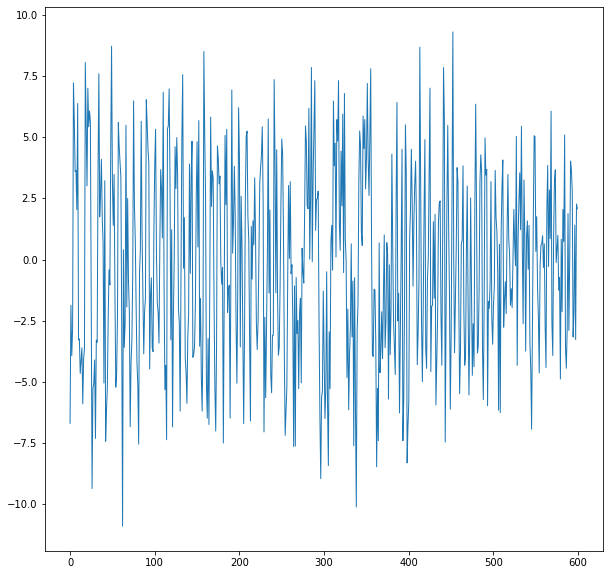

In [15]:
# plot the timeseries
plt.figure(figsize=(10,10))
plt.plot(ev.data[0,5000:5600], linewidth=1)

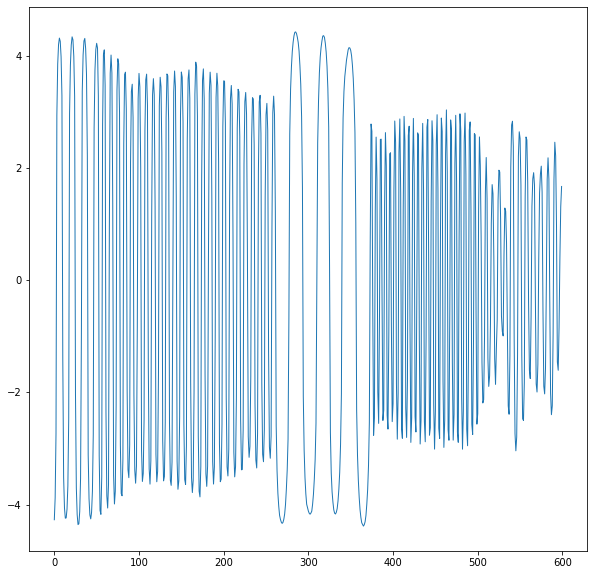

In [16]:
plt.figure(figsize=(10,10))
plt.plot(ev.data_clean[0,5000:5600], linewidth=1)

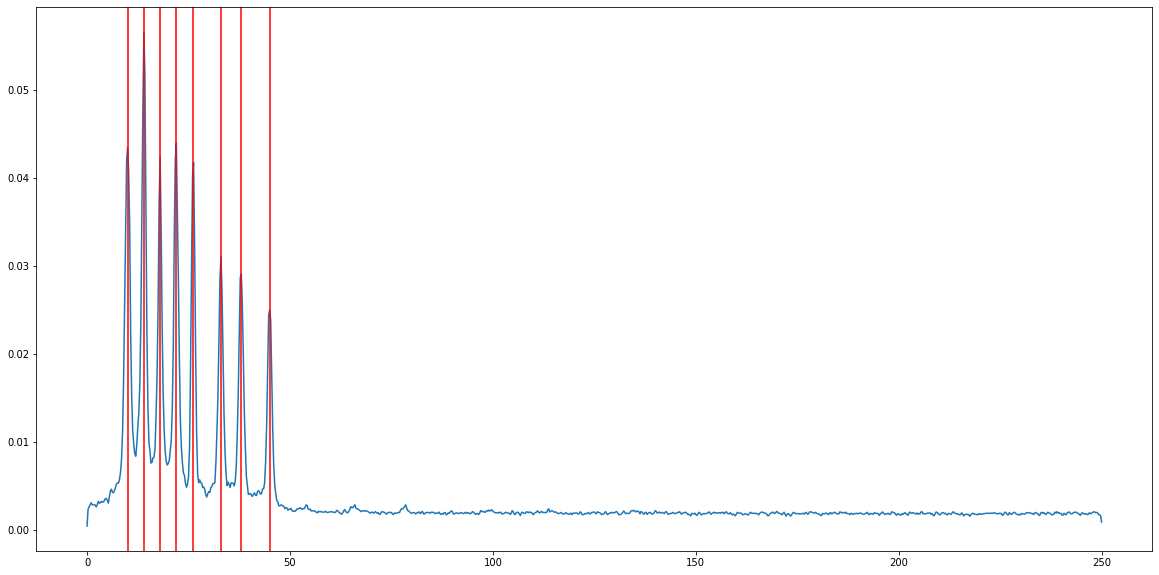

In [31]:
sr = args.sample_rate
f, Pxx_den = welch(ev.data[0,:], sr, nperseg=4*sr)

plt.figure(figsize=(20,10))
plt.plot(f, Pxx_den)

for freq in args.freqs:
    plt.axvline(x=freq, color='red')

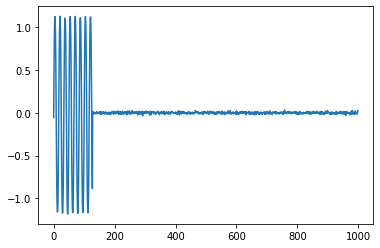

In [118]:
data = np.random.normal(0, 0.01, (250*50))
x = np.arange(128)/250
sine = np.sin(2*np.pi*15*x)
sine = (sine - np.mean(sine))/np.std(sine)
data[:128] += sine
plt.plot(np.arcsinh(data[:1000]))